# Model Export Example

This notebook provides an end-to-end example on how to train and export a PyTorch multi-label classification model to a format accepted by uniVision Module Image ONNX. This will allow you to deploy your models on the Wenglor's B60 Smart Camera and MVC Machine Vision Controller.

DISCLAIMER: Focus of this notebook is to provide an example for the export and quantization. The training code is provided purely for illustration and not meant to provide a production-grade model. You will want to optimize the training pipeline and add more images. Depending on your situation, you can start from one of the following steps: 
1. Train PyTorch model.
    * If you don't have a trained model, start here. 
2. Export PyTorch model to ONNX.
    * If you already have a trained PyTorch model, start here.
3. Quantize ONNX model (optional for B60, not recommemded for MVC).
    * If you have a trained ONNX model and it supports quantization, e.g. the model is in the list of quantization supported models (see below), start here. For this step, you will also need to provide a dataset that your model had been trained on. This dataset will be used for a calibration step during model quantization. 
4. Export ONNX model.
    * If your ONNX model does not support quantization or you cannot provide a calibration dataset, begin here. Similarly, if you plan to deploy your unquantized model on the MVC Machine Vision Controller, this is also the right starting point.  
  
The models below have been tested and are known to run successfully:
* `torchvision.models.quantization.resnet18`
* `torchvision.models.quantization.resnet50`

Other models may also be supported either through execution on the CPU or even hardware-accelerated. Please report your findings and we will update this list.

**What is quantization and why do we need it?**

Quantization is a technique used to make machine learning models run faster and more efficiently, especially on smaller devices with limited resources, like smartphones or smart cameras. By reducing the precision of the numbers the model uses, it can significantly decrease the amount of memory and computing power required, without losing too much accuracy. For example, our benchmark results show that a quantized ResNet50 model running on a B60 camera achieves an inference speed of 50 milliseconds, which is 8.4 times faster than the unquantized version (420 milliseconds). 

## 1. Train PyTorch model 

In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import uuid
from PIL import Image
from sklearn.model_selection import train_test_split
from torcheval.metrics  import MultilabelAccuracy
from torchvision.transforms import v2 as T
from utils.heatmap import get_heatmap_feature_layer
from utils.image import read_image_file

In [2]:
IMAGE_SIZE = (224, 224)
EPOCHS = 50
BATCH_SIZE = 32
NUM_WORKERS = 4
# list of model output classes
CLASSES = ['pencil', 'sharpener', 'tape']
# threshold to use to decide if a class probability enables the relative class 
CLASS_THRESHOLD = 0.5

DATA_ROOT = "../data"
IMAGE_FOLDER = os.path.join(DATA_ROOT, "images/multi-label/")
MODEL_DIR = os.path.join(DATA_ROOT, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The training will use {device} device')

The training will use cuda device


### 1.1 Get dataframe

For this example, we will use a small dataset with some images acquired from a desk. Each image could contain one or more of these office items: a pencil, a sharpener and a adhesive tape. The trained model will be able to detect the presence of these office items.

The images are stored in different folders in the `IMAGE_FOLDER` base path: the name of each folder describes the classes of the images contained. For example, the folder `sharpener-pencil` contains all the images that show a sharpener and a pencil. The class names must match the names in the `CLASSES` list.

In [4]:
# Initialize an empty list to store data to create the dataframe
data = []

# Loop through each subfolder starting from the IMAGE_FOLDER directory
for folder_name in os.listdir(IMAGE_FOLDER):
    folder_path = os.path.join(IMAGE_FOLDER, folder_name)

    if os.path.isdir(folder_path):
        print(f'reading {folder_name} folder...')
        for image_name in os.listdir(folder_path):
            if image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.bmp'):
                row = {'image_path': os.path.join(folder_path, image_name)}
                # Set 1 for each class present in the folder name using the CLASSES list, 0 otherwise
                for c in CLASSES:
                    row[c] = 1 if c in folder_name else 0
                
                data.append(row)

df = pd.DataFrame(data)
df.to_csv(os.path.join(DATA_ROOT, 'train.csv'), index=False, header=True)
df.head(5)

reading pencil folder...
reading tape-sharpener folder...
reading sharpener-pencil folder...
reading sharpener folder...
reading empty folder...
reading tape folder...
reading tape-pencil folder...
reading sharpener-tape-pencil folder...


,image_path,pencil,sharpener,tape
0,../data/images/multi-label/pencil/1e184411-69c...,1,0,0
1,../data/images/multi-label/pencil/56681ca9-d20...,1,0,0
2,../data/images/multi-label/pencil/35667e97-c52...,1,0,0
3,../data/images/multi-label/pencil/0f788808-d02...,1,0,0
4,../data/images/multi-label/pencil/bf5191fe-496...,1,0,0


The user can directly use a `.csv` file without dividing the images into separate folders based on their classes. The file structure must be identical to the one shown in the example.

In [5]:
df = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))

We create the `label_combo` column concatenating the binary class labels. This column will be used later to split the complete dataset in training and validation data keeping a balanced class division. 

In [6]:
df['label_combo'] = df[CLASSES].apply(lambda row: ''.join(str(x) for x in row), axis=1)
df.head(5)

,image_path,pencil,sharpener,tape,label_combo
0,../data/images/multi-label/pencil/1e184411-69c...,1,0,0,100
1,../data/images/multi-label/pencil/56681ca9-d20...,1,0,0,100
2,../data/images/multi-label/pencil/35667e97-c52...,1,0,0,100
3,../data/images/multi-label/pencil/0f788808-d02...,1,0,0,100
4,../data/images/multi-label/pencil/bf5191fe-496...,1,0,0,100


In [7]:
train, valid = train_test_split(df, test_size=0.1, random_state=0, stratify=df.label_combo)
train.shape, valid.shape

((639, 5), (72, 5))

### 1.2 Create dataset

Define image preprocessing and augmentations. For more information on image preprocessing and normalization, please see Export ONNX model. For this example, we will rescale input values to the `[0, 1]` range. For image augmentations, we use random changes in brightness and contrast, along with image rotating and scaling. Depending on your case, different preprocessing and augmentations could be applied. 

In [8]:
train_transform = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.ColorJitter(brightness=0.5, contrast=0.5),
        T.RandomAffine(degrees=(-180, 180), scale=(0.8, 1.2)),
        T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]),
    ]
)
valid_transform = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]),
    ]
)

In [9]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image, target = (
            read_image_file(self.df.image_path.iloc[index]),
            self.df.iloc[index][CLASSES].tolist()
        )

        image = (
            cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            if len(image.shape) == 2 or image.shape[2] == 1
            else image
        )
        
        return self.transform(Image.fromarray(image)), torch.tensor(target, dtype=torch.float32)

In [10]:
train_dataset = ImageDataset(train, train_transform)
valid_dataset = ImageDataset(valid, valid_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
)

### 1.3 Plot images

Check that the selected image preprocessing and augmentations work correctly.  

In [11]:
def plot_images(batch, rows, columns):

    plt.figure(
        figsize=(IMAGE_SIZE[1] // 12, IMAGE_SIZE[0] // 12 * rows // columns),
        frameon=False,
    )

    for index in range(rows * columns):

        plt.subplot(rows, columns, index + 1)
        plt.axis("off")
        plt.imshow(batch[0][index].numpy().transpose(1, 2, 0), aspect="auto")
       
        plt.text(
            IMAGE_SIZE[1] // 2,
            IMAGE_SIZE[0] - 10,
            '\n'.join(CLASSES[idx] for idx, l in enumerate(batch[1][index]) if l==1),
            size=10,
            ha="center",
            color="k",
            bbox=dict(boxstyle="round, pad=0", facecolor="w", edgecolor="w"),
        )
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

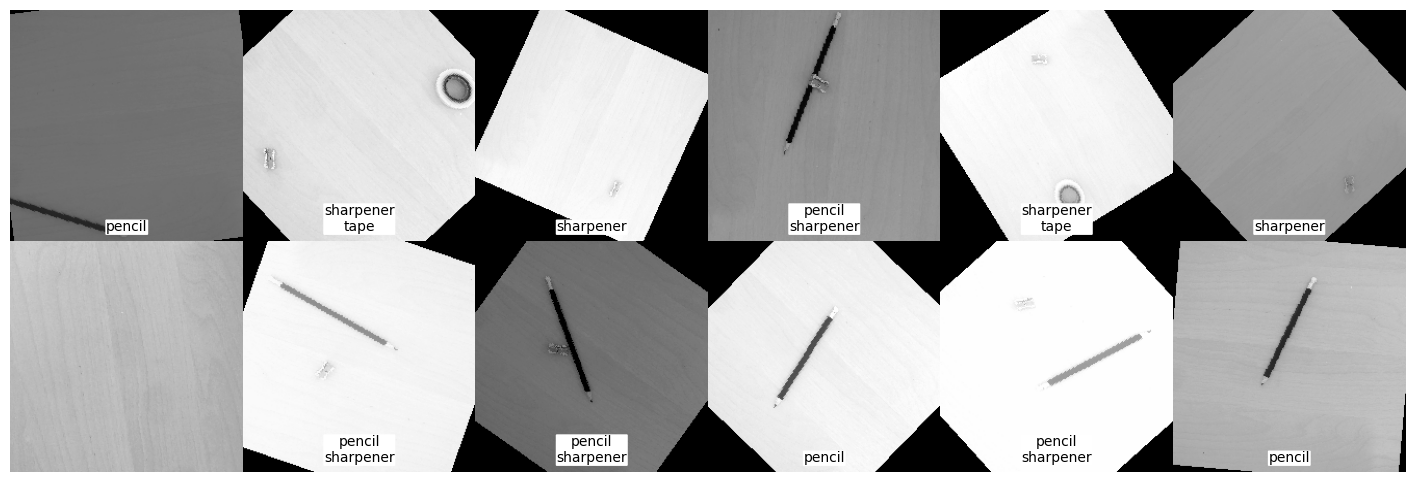

In [12]:
plot_images(next(iter(train_dataloader)), rows=2, columns=6)

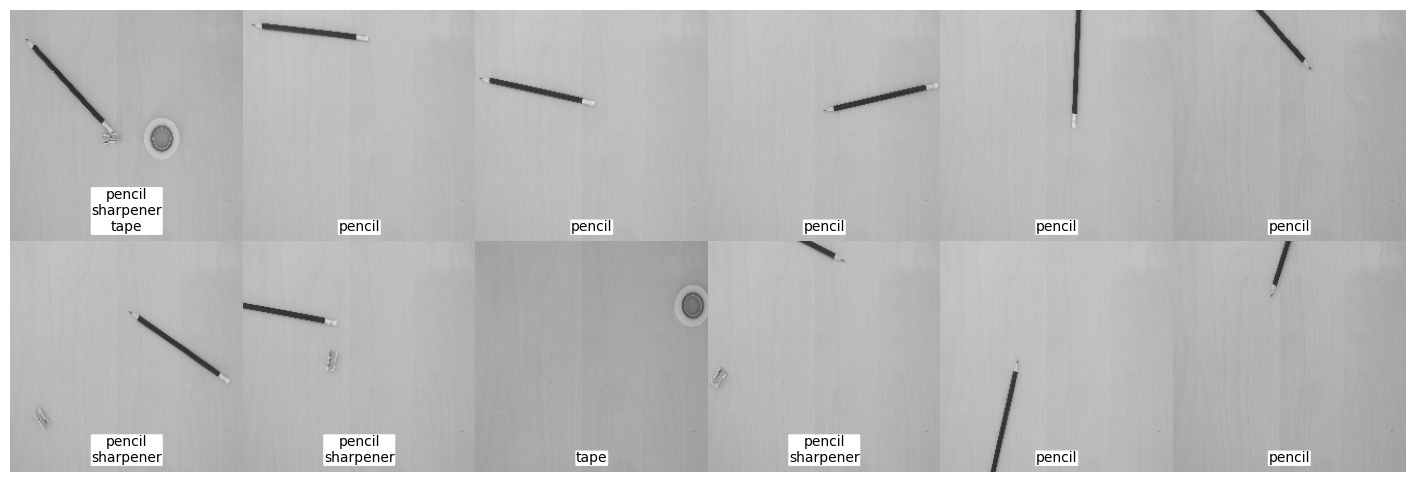

In [13]:
plot_images(next(iter(valid_dataloader)), rows=2, columns=6)

### 1.4 Train model

If you're looking for a model that supports quantization, see the list of quantization supported models at the beginning of the notebook. Otherwise, any model that supports ONNX export with the opset version 11 can be used. 

In [14]:
class Model(torch.nn.Module):
    def __init__(self, classes, return_logits=True):
        super(Model, self).__init__()
        
        self.classes = classes
        self.return_logits = return_logits
        self.backbone = torchvision.models.quantization.resnet18(weights="DEFAULT")
        self.backbone.fc = torch.nn.Linear(
            self.backbone.fc.in_features, out_features=len(self.classes)
        )
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.backbone(x)
        if self.return_logits:
            return x
        return self.sigmoid(x)

In [15]:
def train_model(model, dataloaders):

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(dataloaders["train"]),
        epochs=EPOCHS,
    )
    
    
    metric = MultilabelAccuracy(threshold=CLASS_THRESHOLD).to(device)

    for epoch in range(EPOCHS):

        epoch_log = [f"epoch {epoch+1:04d}/{EPOCHS:04d}"]
        for phase in ["train", "valid"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0
            metric.reset()

            for inputs, target in dataloaders[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    output = model(inputs)
                    loss = criterion(output, target)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)                
                metric.update(output, target)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_metric = metric.compute()

            epoch_log.append(
                f"{phase}_loss: {epoch_loss:.4f} {phase}_multilabel_accuracy: {epoch_metric:.4f}"
            )
        epoch_log.append(f"lr: {scheduler.get_last_lr()[0]:.6f}")
        print(" ".join(epoch_log))

In [16]:
dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
}

model = Model(CLASSES, return_logits=True)
model.to(device)

train_model(model, dataloaders)
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "weights.pth"))

epoch 0001/0050 train_loss: 0.5346 train_multilabel_accuracy: 0.3818 valid_loss: 0.3637 valid_multilabel_accuracy: 0.6806 lr: 0.000051
epoch 0002/0050 train_loss: 0.2962 train_multilabel_accuracy: 0.6886 valid_loss: 0.1680 valid_multilabel_accuracy: 0.8194 lr: 0.000082
epoch 0003/0050 train_loss: 0.1953 train_multilabel_accuracy: 0.7606 valid_loss: 0.0720 valid_multilabel_accuracy: 0.9583 lr: 0.000132
epoch 0004/0050 train_loss: 0.1321 train_multilabel_accuracy: 0.8889 valid_loss: 0.0445 valid_multilabel_accuracy: 1.0000 lr: 0.000200
epoch 0005/0050 train_loss: 0.1053 train_multilabel_accuracy: 0.9249 valid_loss: 0.0585 valid_multilabel_accuracy: 1.0000 lr: 0.000281
epoch 0006/0050 train_loss: 0.0986 train_multilabel_accuracy: 0.9155 valid_loss: 0.0486 valid_multilabel_accuracy: 0.9583 lr: 0.000374
epoch 0007/0050 train_loss: 0.0807 train_multilabel_accuracy: 0.9280 valid_loss: 0.0312 valid_multilabel_accuracy: 0.9861 lr: 0.000472
epoch 0008/0050 train_loss: 0.1220 train_multilabel_acc

In [17]:
# Reinitialize the model with a softmax layer to return probabilities.
model = Model(CLASSES, return_logits=False)
model.to(device)
model.eval()

model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "weights.pth")))

<All keys matched successfully>

## 2. Export PyTorch model to ONNX

If you already have a trained PyTorch model, start here. Please note that in order to run a PyTorch model on Wenglor devices, it should support ONNX export with a specific opset version. Please also note that if you want to quantize your model further, it has to be in the list of quantization supported models at the beginning of the notebook.

In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
FP32_ONNX_MODEL_PATH = os.path.join(MODEL_DIR, "fp32_model.onnx")

In [20]:
# Define your variables and your PyTorch model here.
# IMAGE_SIZE = ...

# model = ...

In [21]:
torch.onnx.export(
    model,
    torch.randn((1, 3, *IMAGE_SIZE)).to(device),
    FP32_ONNX_MODEL_PATH,
    export_params=True,
    verbose=False,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
)

## 3. Quantize ONNX model (optional for B60, not recommemded for MVC)

If you already have a trained ONNX model that supports quantization, start here. This step also requires you to define your training and validation datasets and dataloaders. Please note that if your model has a softmax layer it will be excluded from quantization.

In [22]:
import cv2
import numpy as np
from utils.quantization import quantize_onnx_model

In [23]:
# Define your variables here.
# IMAGE_SIZE = ...
# FP32_ONNX_MODEL_PATH = ...

# train_dataloader = ...
# valid_dataloader = ... (optional)

In [24]:
INT8_ONNX_MODEL_PATH = os.path.join(MODEL_DIR, "int8_model.onnx")

In [25]:
quantize_onnx_model(FP32_ONNX_MODEL_PATH, INT8_ONNX_MODEL_PATH, train_dataset)

### 3.1 Compare FP32 and INT8 models (optional)

If you have a validation dataset, you can measure the performance of your model before and after quantization.  

In [26]:
dnn = cv2.dnn.readNetFromONNX(FP32_ONNX_MODEL_PATH)
dnn.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
dnn.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

y_true, y_prob = [], []
for inputs, target in valid_dataloader:
    dnn.setInput(inputs.numpy())
    output = dnn.forward()
    y_true.append(target)
    y_prob.append(output)

y_true, y_prob = np.concatenate(y_true), np.concatenate(y_prob)
y_pred = [[1 if p >= CLASS_THRESHOLD else 0 for p in probs] for probs in y_prob]

In [27]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, roc_auc_score, average_precision_score
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print(f"Model Precision")
print(f'  pencil: {precision[0]:.3f}')
print(f'  sharpener: {precision[1]:.3f}')
print(f'  tape: {precision[2]:.3f}')

Model Precision
  pencil: 1.000
  sharpener: 1.000
  tape: 1.000


In [28]:
dnn = cv2.dnn.readNetFromONNX(INT8_ONNX_MODEL_PATH)
dnn.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
dnn.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

y_true, y_prob = [], []
for inputs, target in valid_dataloader:
    dnn.setInput(inputs.numpy())
    output = dnn.forward()

    y_true.append(target)
    y_prob.append(output)

y_true, y_prob = np.concatenate(y_true), np.concatenate(y_prob)
y_pred = [[1 if p >= CLASS_THRESHOLD else 0 for p in probs] for probs in y_prob]

In [29]:
precision = precision_score(y_true, y_pred, average=None)
print(f"Model Precision")
print(f'  pencil: {precision[0]:.3f}')
print(f'  sharpener: {precision[1]:.3f}')
print(f'  tape: {precision[2]:.3f}')

Model Precision
  pencil: 1.000
  sharpener: 1.000
  tape: 1.000


## 4. Export ONNX model

If your ONNX model cannot be quantized but was exported to ONNX with the supported opset version, it can still be run on a B60 camera or an MVC Machine Vision Controller using CPU. If your model, on the other hand, supports quantization, it could be run on a B60 camera using NPU.

### 4.1 YAML format

During model export, a metadata `.yaml` file is generated, which contains all the necessary information about the model, such as the input size, class names, etc. Please review the example metadata file and its description below. The complete list of parameters and their description is present in the `metadata.md` file stored in the root directory.

#### 4.1.1 `.yaml` metadata file example

```
%YAML 1.2
---
metadata_version: '1.0.0'
model_uuid: '06f8a78c-e45a-4a86-a034-9deff53d8832'
creation_time: '2024-12-03T15:35:42'
quantization: INT8
heatmap_feature_layer: '/backbone/layer4/layer4.1/Add_quant'
dataset_color_mode: MONOCHROME
input:
  width: 224
  height: 224
  channels: 3
  unit_scaling: true
  standardization_std: # optional
  - 0.485
  - 0.456
  - 0.406
  standardization_mean: # optional
  - 0.229
  - 0.224
  - 0.225
  channel_order: NCHW
  color_space: RGB
outputs:
  - type: MULTI_LABEL_CLASSIFICATION
    classes:
      - uuid: '83274b42-8050-41cf-a5a3-9e54418b4772'
        name: 'pencil'
        default_threshold: 0.5
      - uuid: '5f740e12-9744-4b21-9f21-d428b5ad24eb'
        name: 'sharpener'
        default_threshold: 0.5
      - uuid: '93766c15-3923-4203-be41-2f7a568b006e'
        name: 'tape'
        default_threshold: 0.5
```

### 4.2 Heatmap feature layer (optional)

Saliency map generation methods help us understand which parts of an image or a machine learning model focuses on to make its decisions. This makes AI models more transparent and easier to trust because we can see what is important to the model when it makes certain predictions.

In [30]:
# For FP32 ONNX model
heatmap_feature_layer_fp32 = get_heatmap_feature_layer("resnet18", quantization=False)
heatmap_feature_layer_fp32

'/backbone/layer4/layer4.1/Add'

In [31]:
# For INT8 ONNX model
heatmap_feature_layer_int8 = get_heatmap_feature_layer("resnet18", quantization=True)
heatmap_feature_layer_int8

'/backbone/layer4/layer4.1/Add_quant'

### 4.3 Export

We can export either an FP32 or an INT8 ONNX model. The result is the `.onnx` file together with a metadata file, zipped together as a `.u3o` file. In univision, the `.u3o` file can be loaded with the `module image onnx`.
Please see the examples below.

In [32]:
import cv2
import numpy as np
from utils.enums import DatasetColorMode
from utils.export import export_classification_model
from utils.image import is_rgb_image, read_and_resize_input_example, read_image_file

We also need to define a dataset color mode. For more information please refer to the `.yaml` metadata file description. 

In [33]:
if any(is_rgb_image(path) for path in df.image_path):
    dataset_color_mode = DatasetColorMode.COLOR
else:
    dataset_color_mode = DatasetColorMode.MONOCHROME

dataset_color_mode

<DatasetColorMode.MONOCHROME: 'MONOCHROME'>

In [34]:
# Define an input example. If you cannot provide an example, an array of zeros can be used.
input_example = read_and_resize_input_example(
    df.image_path.iloc[0], IMAGE_SIZE, dataset_color_mode
)

#### 4.3.1 Export FP32 ONNX model

In [35]:
UNIVISION_FP32_MODEL_PATH = os.path.join(MODEL_DIR, "example_fp32_model.u3o")

In [36]:
# Define your variables here.
# IMAGE_SIZE = ...
# FP32_ONNX_MODEL_PATH = ... 

# classes = ...
# df = ... (optional)

In [37]:
export_classification_model(
    univision_model_path=UNIVISION_FP32_MODEL_PATH,
    onnx_model_path=FP32_ONNX_MODEL_PATH,
    classes=CLASSES,
    input_example=input_example,
    model_name=None,  # or e.g. "example_model_name"
    model_uuid=str(uuid.uuid4()),
    quantization=None,
    unit_scaling=True,
    standardization_std=None,
    standardization_mean=None,
    channel_order="NCHW",
    dataset_color_mode=dataset_color_mode,
    input_color_space="RGB",
    output_type="MULTI_LABEL_CLASSIFICATION",
    heatmap_feature_layer=heatmap_feature_layer_fp32,  # or None
    class_thresholds=[CLASS_THRESHOLD] * len(CLASSES),
)

#### 4.3.2 Export INT8 ONNX model

In [38]:
UNIVISION_INT8_MODEL_PATH = os.path.join(MODEL_DIR, "example_int8_model.u3o")

In [39]:
# Define your variables here.
# IMAGE_SIZE = ...
# INT8_ONNX_MODEL_PATH = ...

# classes = ...
# df = ... (optional)

In [40]:
export_classification_model(
    univision_model_path=UNIVISION_INT8_MODEL_PATH,
    onnx_model_path=INT8_ONNX_MODEL_PATH,
    classes=CLASSES,
    input_example=input_example,
    model_name=None,  # or e.g. "example_model_name"
    model_uuid=str(uuid.uuid4()),
    quantization="INT8",
    unit_scaling=True,
    standardization_std=None,
    standardization_mean=None,
    channel_order="NCHW",
    dataset_color_mode=dataset_color_mode,
    input_color_space="RGB",
    output_type="MULTI_LABEL_CLASSIFICATION",
    heatmap_feature_layer=heatmap_feature_layer_int8,  # or None
    class_thresholds=[CLASS_THRESHOLD] * len(CLASSES),
)